In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Goals

We'd like to figure out if we got useful, valid data out from our (a) cleaning and (b) spreadsheet-computing processes.

The first thing I know how to do is generate the classic "noise vs magnitude" plots for each graph, under identical selection conditions. There are other valuable diagnostic plots to generate, too, and I probably have code lying around somewhere for each of them, but for now.... this is the first and obvious thing to do.

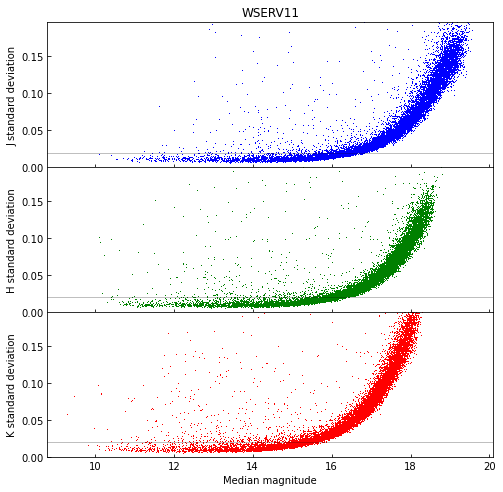

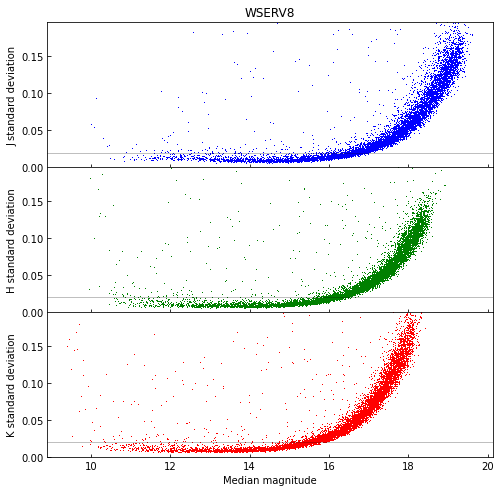

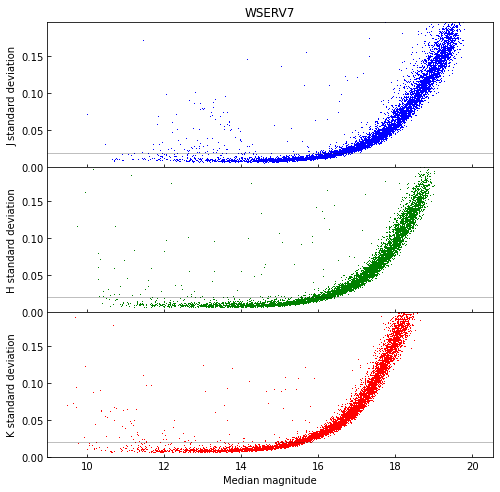

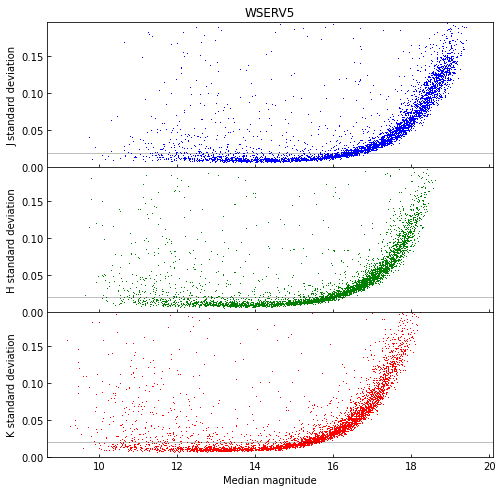

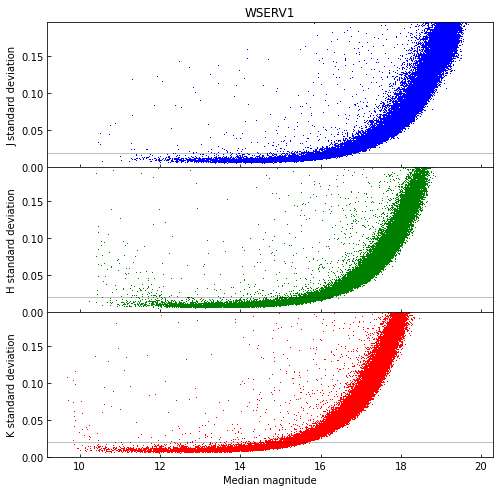

In [2]:
wserv_ids = [1, 5, 7, 8, 11]
# wserv_ids = [5]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )
#     if wserv==5:
#         output_path = os.path.join(
#             output_root, 
#             "wserv5_v2012",
#             f"WSERV{str(wserv)}_fdece_graded_clipped0.8_scrubbed0.1_dusted0.5_summary_spreadsheet.h5")

    ds = pd.read_hdf(output_path, key='table')
    
    q_2_all_indices = (
        (ds["count"]["N_J"] > 30)
        & (ds["count"]["N_J"] < 160)
        & (ds["count"]["N_H"] > 30)
        & (ds["count"]["N_H"] < 160)
        & (ds["count"]["N_K"] > 30)
        & (ds["count"]["N_K"] < 160)
        & (ds["max"]["JPPERRBITS"] == 0)
        & (ds["max"]["HPPERRBITS"] == 0)
        & (ds["max"]["KPPERRBITS"] == 0)
        & (ds["median"]["PSTAR"] > 0.75)
    )
    
    q3 = (
        (ds["count"]["N_J"] > 50)
        & (ds["count"]["N_J"] < 150)
        & (ds["count"]["N_H"] > 50)
        & (ds["count"]["N_H"] < 150)
        & (ds["count"]["N_K"] > 50)
        & (ds["count"]["N_K"] < 150)
        & (ds["count"]["N_J_info"] + ds["count"]["N_J_warn"] + ds["count"]["N_J_severe"] <= 25)
        & (ds["count"]["N_H_info"] + ds["count"]["N_H_warn"] + ds["count"]["N_H_severe"] <= 25)
        & (ds["count"]["N_K_info"] + ds["count"]["N_K_warn"] + ds["count"]["N_K_severe"] <= 25)
        & (ds["median"]["PSTAR"] > 0.75)
    )
    
    fig, axes = plt.subplots(3, sharex=True, figsize=(8,8))
    
    axes[0].plot(ds['median']['JAPERMAG3'][q3], ds['std']['JAPERMAG3'][q3], 'b,')
    axes[1].plot(ds['median']['HAPERMAG3'][q3], ds['std']['HAPERMAG3'][q3], 'g,')
    axes[2].plot(ds['median']['KAPERMAG3'][q3], ds['std']['KAPERMAG3'][q3], 'r,')

    for ax, band in zip(axes, ["J", "H", "K"]):
        ax.axhline(0.02, color='k', alpha=0.5, lw=0.5)
        ax.set_ylim(0, 0.195)

        ax.set_ylabel(f"{band} standard deviation")
        ax.tick_params(direction='in')
        
    axes[2].set_xlabel("Median magnitude")
    axes[0].set_title(f"WSERV{wserv}")
    plt.subplots_adjust(hspace=0)
    

# Notes

All of these look good except for WSERV5 -- which is wildly ironic, since I developed this whole diagnostic/selection criteria based entirely on WSERV5's data in the first place. What in the world has happened? At least the others look good.

I want to re-generate some other plots, especially the map figure that has the counts of "number of JHK observations per tile that remain after cleaning". I know such a code exists somewhere, and we deserve to get it here.

I wouldn't be surprised if I need to scale back on the cleaning threshold (from 95 to 80%) for WSERV5. But I'm also not confident that this is the key.

Also next: count the Q2/Q1/Q0 stars in each dataset.

# Unclean spreadsheets

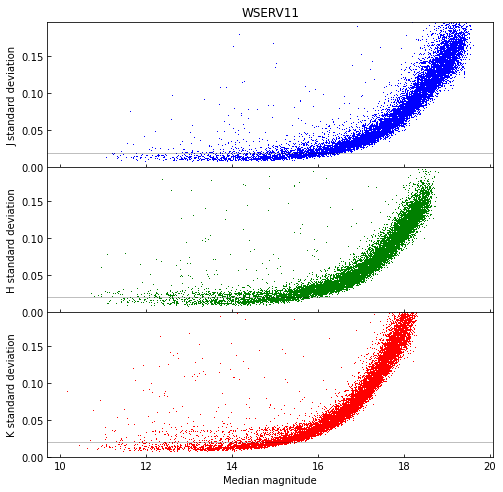

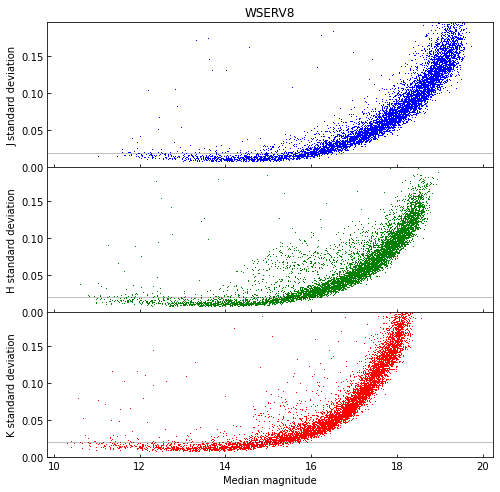

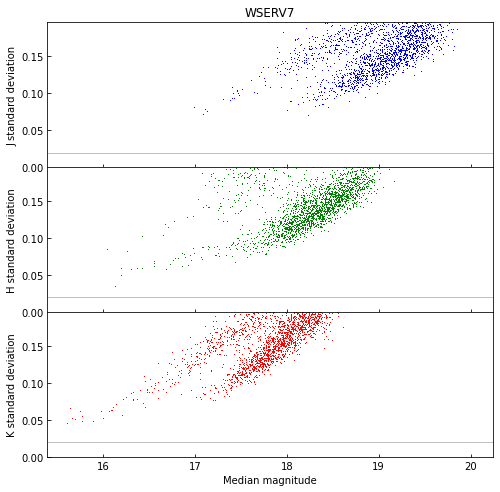

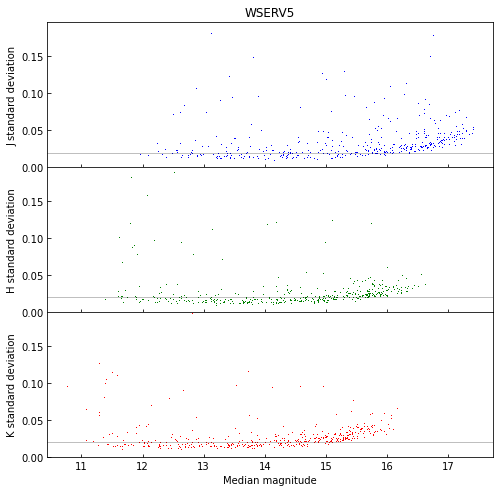

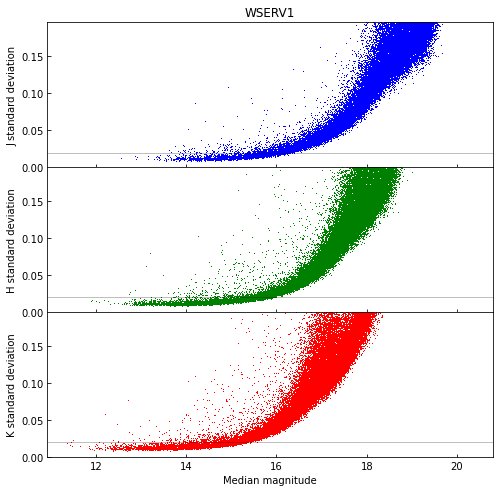

In [3]:
wserv_ids = [1, 5, 7, 8, 11]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_uncleaned_summary_spreadsheet.h5",
    )

    ds = pd.read_hdf(output_path, key='table')
    
    q2_all_indices = (
        (ds["count"]["N_J"] > 40)
        & (ds["count"]["N_J"] < 160)
        & (ds["count"]["N_H"] > 40)
        & (ds["count"]["N_H"] < 160)
        & (ds["count"]["N_K"] > 40)
        & (ds["count"]["N_K"] < 160)
        & (ds["max"]["JPPERRBITS"] == 0)
        & (ds["max"]["HPPERRBITS"] == 0)
        & (ds["max"]["KPPERRBITS"] == 0)
        & (ds["median"]["PSTAR"] > 0.75)
    )
    
    fig, axes = plt.subplots(3, sharex=True, figsize=(8,8))
    
    axes[0].plot(ds['median']['JAPERMAG3'][q2_all_indices], ds['std']['JAPERMAG3'][q2_all_indices], 'b,')
    axes[1].plot(ds['median']['HAPERMAG3'][q2_all_indices], ds['std']['HAPERMAG3'][q2_all_indices], 'g,')
    axes[2].plot(ds['median']['KAPERMAG3'][q2_all_indices], ds['std']['KAPERMAG3'][q2_all_indices], 'r,')

    for ax, band in zip(axes, ["J", "H", "K"]):
        ax.axhline(0.02, color='k', alpha=0.5, lw=0.5)
        ax.set_ylim(0, 0.195)

        ax.set_ylabel(f"{band} standard deviation")
        ax.tick_params(direction='in')
        
    axes[2].set_xlabel("Median magnitude")
    axes[0].set_title(f"WSERV{wserv}")
    plt.subplots_adjust(hspace=0)
    

# Next goal:
compare (median) estimated errors with actual rms.

In [4]:
def uncorrected_error(M, s=0.021, c=1.082):
    """
    M^2 = cE^2 + s^2 
    therefore
    E = sqrt( (M^2 - s^2) / c )
    """
    
    E = np.sqrt( (M**2 - s**2) / c )

    return E

uncorrected_error(0.025)

0.013040531157321192

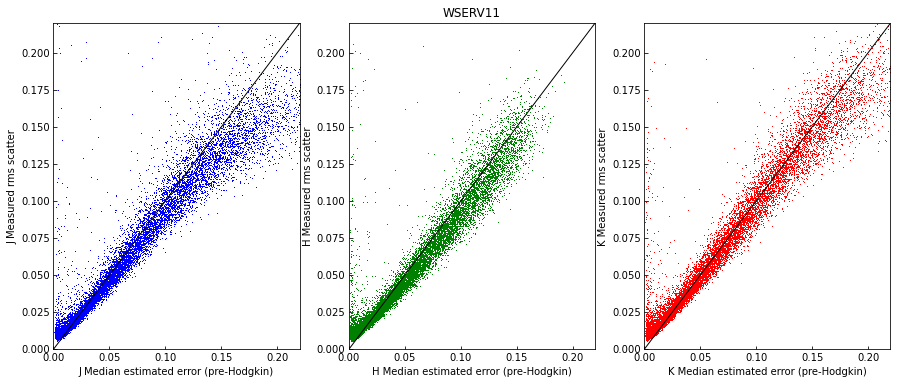

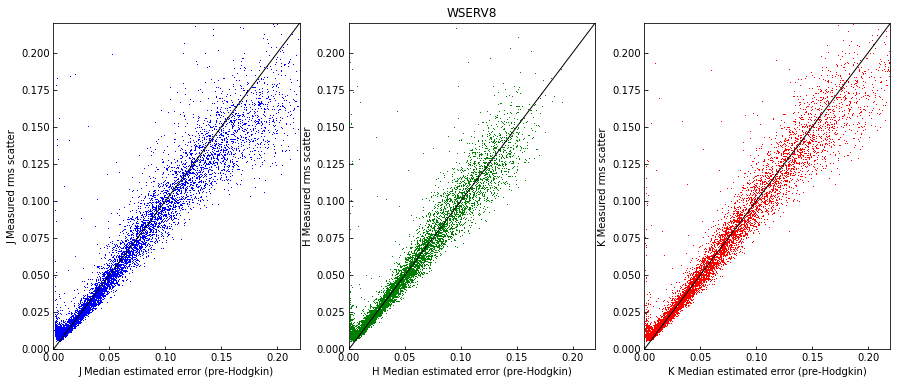

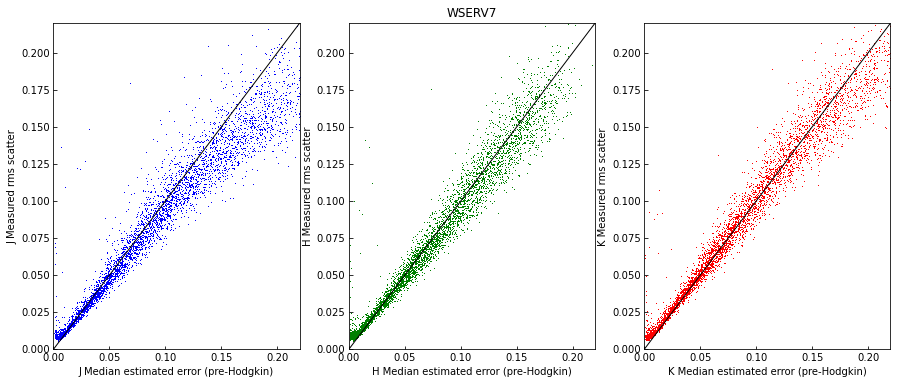

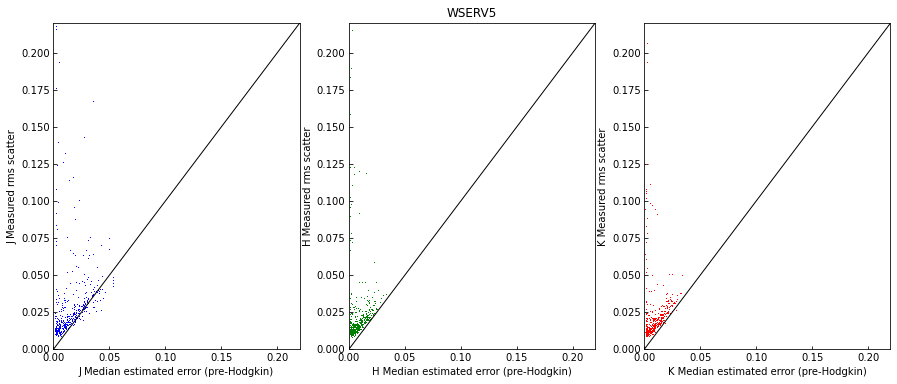

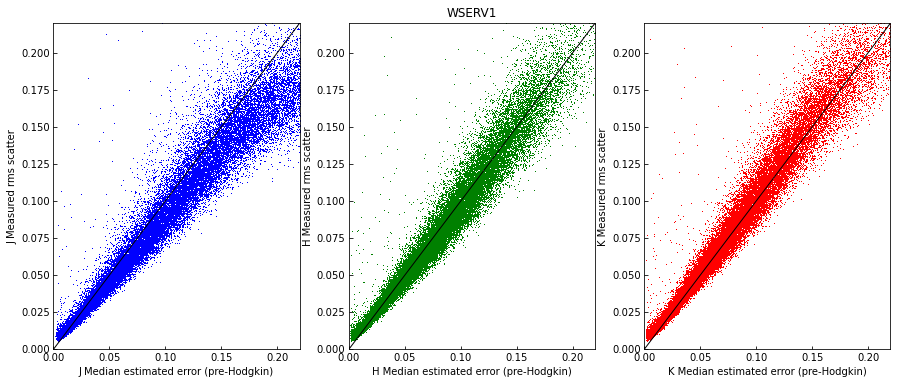

In [5]:
wserv_ids = [1, 5, 7, 8, 11]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )
    if wserv==5:
        output_path = os.path.join(
            output_root, 
            "wserv5_v2012",
            f"WSERV{str(wserv)}_fdece_graded_clipped0.8_scrubbed0.1_dusted0.5_summary_spreadsheet.h5")
    

    ds = pd.read_hdf(output_path, key='table')
    
    q2_all_indices = (
        (ds["count"]["N_J"] > 40)
        & (ds["count"]["N_J"] < 160)
        & (ds["count"]["N_H"] > 40)
        & (ds["count"]["N_H"] < 160)
        & (ds["count"]["N_K"] > 40)
        & (ds["count"]["N_K"] < 160)
        & (ds["max"]["JPPERRBITS"] == 0)
        & (ds["max"]["HPPERRBITS"] == 0)
        & (ds["max"]["KPPERRBITS"] == 0)
        & (ds["median"]["PSTAR"] > 0.75)
    )
    
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,6))
    
    axes[0].plot(uncorrected_error(ds['median']['JAPERMAG3ERR'][q2_all_indices]), ds['std']['JAPERMAG3'][q2_all_indices], 'b,')
    axes[1].plot(uncorrected_error(ds['median']['HAPERMAG3ERR'][q2_all_indices]), ds['std']['HAPERMAG3'][q2_all_indices], 'g,')
    axes[2].plot(uncorrected_error(ds['median']['KAPERMAG3ERR'][q2_all_indices]), ds['std']['KAPERMAG3'][q2_all_indices], 'r,')

    for ax, band in zip(axes, ["J", "H", "K"]):
#         ax.axhline(0.02, color='k', alpha=0.5, lw=0.5)
        ax.plot([0,1],[0,1], color='k', alpha=1, lw=1, scalex=False, scaley=False)
        ax.set_ylim(0, 0.22)
        ax.set_xlim(0, 0.22)

        ax.set_xlabel(f"{band} Median estimated error (pre-Hodgkin)")
        ax.set_ylabel(f"{band} Measured rms scatter")
        ax.tick_params(direction='in')
        
    axes[1].set_title(f"WSERV{wserv}")
#     plt.subplots_adjust(hspace=0)

    

# What?
The thing I seem to have learned from the above: some of the errorbars are ... not the values I thought they were. (Possibility: they had the null sentinel value earlier, and I foolishly didn't account for that when doing the error-correction in the reduction step.)

Is the error correction math reversible? Can I recover the original values by inverting the equation I used? Let's find out...

The equation is:
$$ M^2 = cE^2 + s^2$$
with these parameters:

$M$: the measured error
$E$: the estimated error
$s$: systematic component
$c$: constant

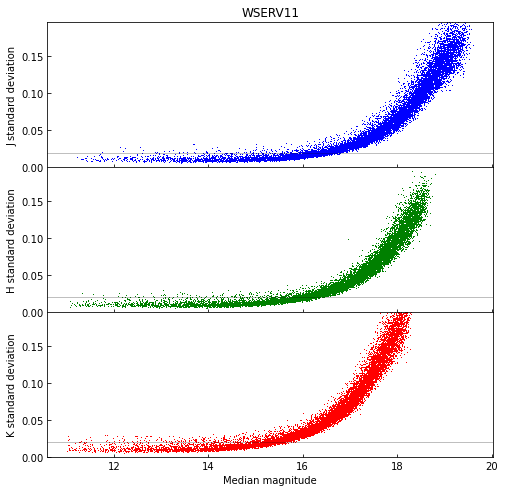

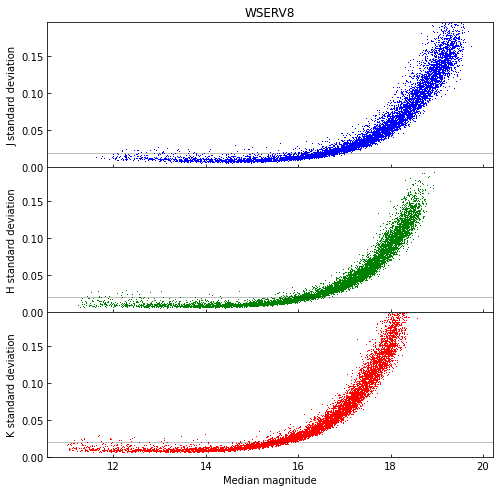

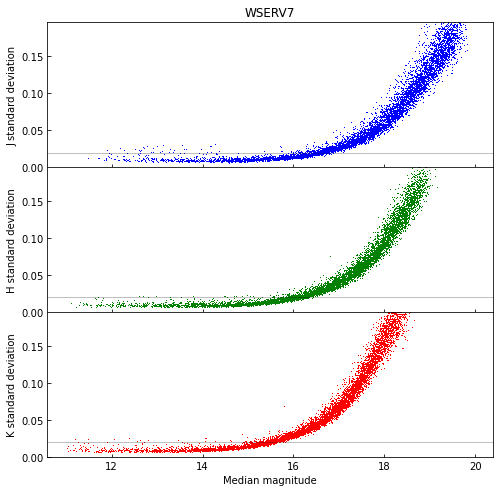

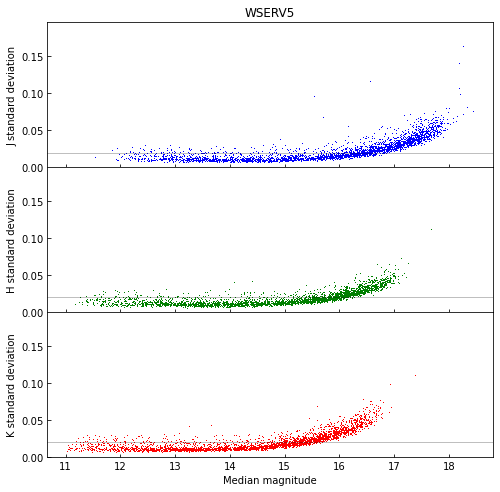

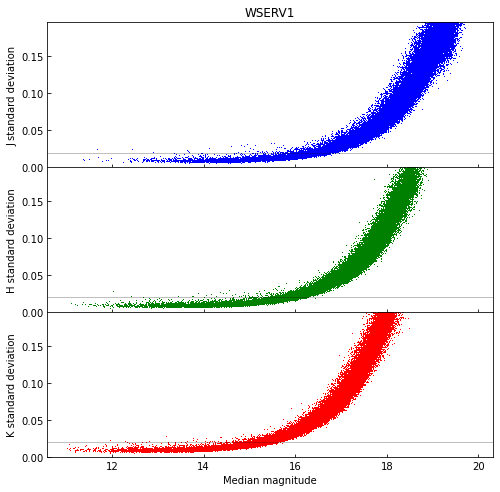

In [51]:
wserv_ids = [1, 5, 7, 8, 11]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )

    ds = pd.read_hdf(output_path, key='table')
    
    q2_all_indices_nonvariable = (
        (ds["count"]["N_J"] > 40)
        & (ds["count"]["N_J"] < 160)
        & (ds["count"]["N_H"] > 40)
        & (ds["count"]["N_H"] < 160)
        & (ds["count"]["N_K"] > 40)
        & (ds["count"]["N_K"] < 160)
        & (ds['median']['JAPERMAG3'] > 11)
        & (ds['median']['HAPERMAG3'] > 11)
        & (ds['median']['KAPERMAG3'] > 11)
        & (ds["count"]["N_J_good"] == ds["count"]["N_J"])
        & (ds["count"]["N_H_good"] == ds["count"]["N_H"])
        & (ds["count"]["N_K_good"] == ds["count"]["N_K"])
        & (ds["median"]["PSTAR"] > 0.75)
        & (ds['variability']['J_red_chisq'] < 2)
        & (ds['variability']['H_red_chisq'] < 2)
        & (ds['variability']['K_red_chisq'] < 2)
    )
    
    fig, axes = plt.subplots(3, sharex=True, figsize=(8,8))
    
    axes[0].plot(ds['median']['JAPERMAG3'][q2_all_indices_nonvariable], ds['std']['JAPERMAG3'][q2_all_indices_nonvariable], 'b,')
    axes[1].plot(ds['median']['HAPERMAG3'][q2_all_indices_nonvariable], ds['std']['HAPERMAG3'][q2_all_indices_nonvariable], 'g,')
    axes[2].plot(ds['median']['KAPERMAG3'][q2_all_indices_nonvariable], ds['std']['KAPERMAG3'][q2_all_indices_nonvariable], 'r,')

    for ax, band in zip(axes, ["J", "H", "K"]):
        ax.axhline(0.02, color='k', alpha=0.5, lw=0.5)
        ax.set_ylim(0, 0.195)

        ax.set_ylabel(f"{band} standard deviation")
        ax.tick_params(direction='in')
        
    axes[2].set_xlabel("Median magnitude")
    axes[0].set_title(f"WSERV{wserv}")
    plt.subplots_adjust(hspace=0)
    
    

/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.015e+03, 1.235e+03, 1.252e+03, 1.490e+03, 2.039e+03, 2.966e+03,
        3.951e+03, 4.195e+03, 3.627e+03, 2.640e+03, 1.750e+03, 1.166e+03,
        7.150e+02, 5.260e+02, 4.270e+02, 3.230e+02, 2.460e+02, 1.930e+02,
        1.440e+02, 1.180e+02, 1.170e+02, 1.120e+02, 1.000e+02, 8.100e+01,
        6.700e+01, 7.800e+01, 6.600e+01, 5.400e+01, 4.900e+01, 3.800e+01,
        5.000e+01, 5.100e+01, 2.500e+01, 2.900e+01, 3.300e+01, 3.600e+01,
        3.100e+01, 2.100e+01, 1.900e+01, 3.100e+01, 1.700e+01, 2.000e+01,
        2.400e+01, 1.800e+01, 1.700e+01, 1.800e+01, 2.000e+01, 1.700e+01,
        1.700e+01, 2.200e+01, 1.700e+01, 1.400e+01, 2.100e+01, 1.600e+01,
        8.000e+00, 1.700e+01, 1.100e+01, 1.400e+01, 9.000e+00, 1.600e+01,
        1.000e+01, 1.100e+01, 1.000e+01, 8.000e+00, 1.100e+01, 9.000e+00,
        6.000e+00, 1.000e+01, 6.000e+00, 8.000e+00, 1.000e+01, 1.000e+01,
        9.000e+00, 9.000e+00, 4.000e+00, 9.000e+00, 7.000e+00, 6.000e+00,
        9.000e+00, 8.000e+00, 8.000e+0

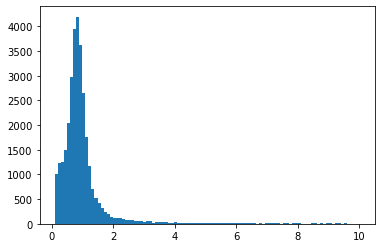

In [24]:
plt.hist(ds['variability']['K_red_chisq'], bins=100, range=(0.1,10))

In [25]:
b = 'J'
bins=10
bin_range=None
mags = ds["median"][f"{b}APERMAG3"]
bin_range = np.nanmin(mags), np.nanmax(mags)
hist, bin_edges = np.histogram(mags, bins=bins, range=bin_range)
bin_lefts, bin_rights = bin_edges[:-1], bin_edges[1:]


In [26]:
bin_lefts, bin_rights

(array([ 8.89157581, 10.07449522, 11.25741463, 12.44033403, 13.62325344,
        14.80617285, 15.98909225, 17.17201166, 18.35493107, 19.53785048]),
 array([10.07449522, 11.25741463, 12.44033403, 13.62325344, 14.80617285,
        15.98909225, 17.17201166, 18.35493107, 19.53785048, 20.72076988]))

In [27]:
dsn = ds[q2_all_indices_nonvariable]


In [28]:
%run ../rederive_error_correction.py

In [29]:
output = bin_the_median_errorbars_by_magnitude(dsn, bins=20)

In [30]:
output

defaultdict(dict,
            {'J': {'mag_bin_center': array([11.4367116 , 11.85582342, 12.27493525, 12.69404707, 13.11315889,
                     13.53227072, 13.95138254, 14.37049437, 14.78960619, 15.20871801,
                     15.62782984, 16.04694166, 16.46605349, 16.88516531, 17.30427713,
                     17.72338896, 18.14250078, 18.56161261, 18.98072443, 19.39983625]),
              'measured_error': [0.009566610679030418,
               0.00980437221005559,
               0.010921545326709747,
               0.009593622758984566,
               0.010215389542281628,
               0.00932607427239418,
               0.00949622131884098,
               0.009659312665462494,
               0.0098704993724823,
               0.01087187323719263,
               0.012128702830523252,
               0.01524966349825263,
               0.019255385734140873,
               0.02579348161816597,
               0.03602367639541626,
               0.050900885835289955,
            

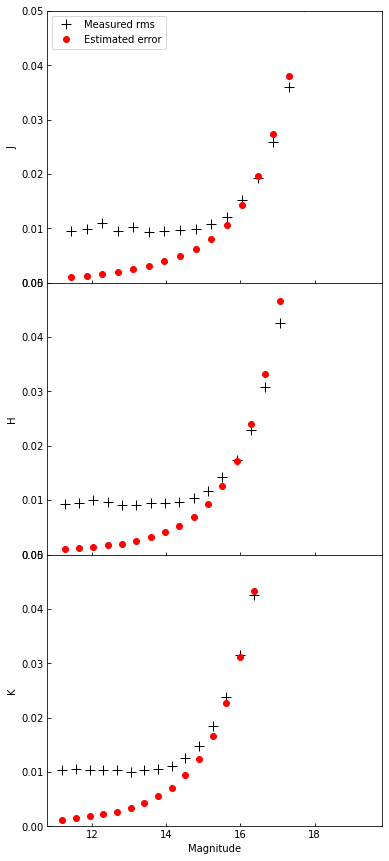

In [44]:
fig, axes = plt.subplots(3, sharex=True, figsize=(6,15))

for i, b in enumerate(["J", "H", "K"]):

    axes[i].plot(output[b]['mag_bin_center'], output[b]['measured_error'], 'k+', ms=10, label='Measured rms')
    axes[i].plot(output[b]['mag_bin_center'], output[b]['estimated_error'], 'ro', label='Estimated error')
    axes[i].set_ylabel(b)
    axes[i].tick_params(direction='in')
    axes[i].set_ylim(0, 0.05)

axes[0].legend()
axes[2].set_xlabel("Magnitude")
plt.subplots_adjust(hspace=0)


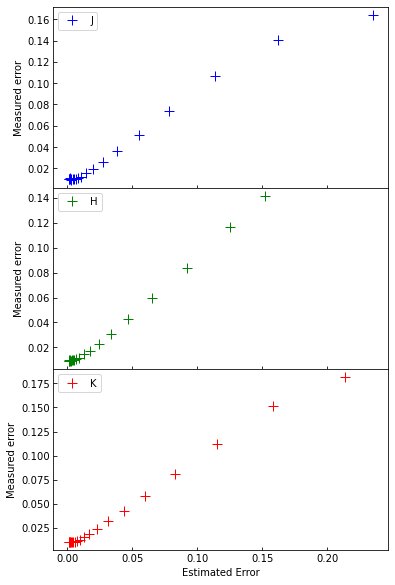

In [32]:
fig, axes = plt.subplots(3, sharex=True, figsize=(6,10))
colors=['b','g','r']

for i, b in enumerate(["J", "H", "K"]):

    axes[i].plot(output[b]['estimated_error'], output[b]['measured_error'], f'{colors[i]}+', ms=10, label=b)
#     axes[i].plot(output[b]['mag_bin_center'], output['J']['estimated_error'], 'ro', label='Estimated error')
    axes[i].set_ylabel("Measured error")
    axes[i].tick_params(direction='in')
#     axes[i].set_ylim(0, 0.05)

    axes[i].legend(loc='upper left')
axes[2].set_xlabel("Estimated Error")
plt.subplots_adjust(hspace=0)


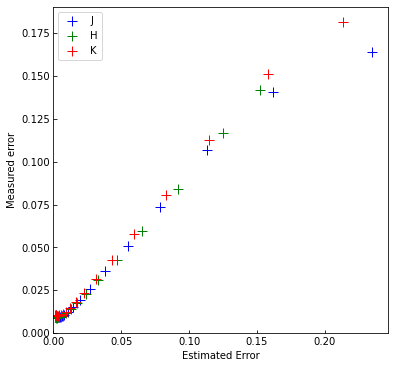

In [33]:
fig, ax = plt.subplots(1, figsize=(6,6))
colors=['b','g','r']
for i, b in enumerate(["J", "H", "K"]):

    ax.plot(output[b]['estimated_error'], output[b]['measured_error'], f'{colors[i]}+', ms=10, label=b)
ax.tick_params(direction='in')
ax.set_ylabel("Measured error")
ax.set_xlabel("Estimated Error")
ax.set_ylim(0, None)
ax.set_xlim(0, None)
ax.legend()
plt.subplots_adjust(hspace=0)


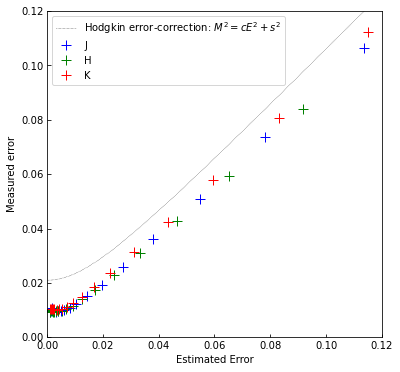

In [34]:
fig, ax = plt.subplots(1, figsize=(6,6))
colors=['b','g','r']

xs = np.linspace(0, 0.25, 200)
c = 1.082
s = 0.021
ys = np.sqrt(c*xs**2 + s**2)
ax.plot(xs, ys, 'k:', lw=0.5, label='Hodgkin error-correction: $M^2 = cE^2 + s^2$')
# ax.plot(xs, xs, 'k--', lw=0.5, label='Unity line ($M=E$)')

for i, b in enumerate(["J", "H", "K"]):

    ax.plot(output[b]['estimated_error'], output[b]['measured_error'], f'{colors[i]}+', ms=10, label=b)
ax.tick_params(direction='in')
ax.set_ylabel("Measured error")
ax.set_xlabel("Estimated Error")
ax.set_ylim(0, 0.12)
ax.set_xlim(0, 0.12)
ax.legend()



In [43]:
curve_fit?

/Users/tsrice/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


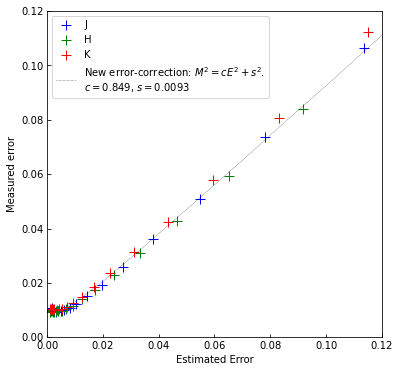

In [42]:
from scipy.optimize import curve_fit

def Hodgkin_error_formula(x, c, s):
    y = (c*x**2 + s**2)**0.5
    return y

fig, ax = plt.subplots(1, figsize=(6,6))
colors=['b','g','r']

# xs = np.linspace(0, 0.25, 200)
# c = 1.082
# s = 0.021
# ys = np.sqrt(c*xs**2 + s**2)
# ax.plot(xs, ys, 'k:', lw=0.5, label='Hodgkin error-correction: $M^2 = cE^2 + s^2$')
# ax.plot(xs, xs, 'k--', lw=0.5, label='Unity line ($M=E$)')

x = []
y = []

for i, b in enumerate(["J", "H", "K"]):

    ax.plot(output[b]['estimated_error'], output[b]['measured_error'], f'{colors[i]}+', ms=10, label=b)
    
    x.extend(output[b]['estimated_error'])
    y.extend(output[b]['measured_error'])

x_arr = np.array(x)
y_arr = np.array(y)
valid = y_arr < 0.15

curve_output = curve_fit(Hodgkin_error_formula, x_arr[valid], y_arr[valid])

xs = np.linspace(0, 0.25, 200)
c = curve_output[0][0]
s = curve_output[0][1]
ys = np.sqrt(c*xs**2 + s**2)
ax.plot(xs, ys, 'k:', lw=0.5, label=f'New error-correction: $M^2 = cE^2 + s^2$.\n$c={c:.3f}$, $s={s:.4f}$')

ax.tick_params(direction='in')
ax.set_ylabel("Measured error")
ax.set_xlabel("Estimated Error")
ax.set_ylim(0, 0.12)
ax.set_xlim(0, 0.12)
ax.legend()

In [50]:
np.sqrt(curve_output[1][0,0]), np.sqrt(curve_output[1][1,1])

(0.009119435878903829, 0.0003271850505817945)

In [ ]:
wserv_ids = [1, 5, 7, 8, 11]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )

    ds = pd.read_hdf(output_path, key='table')
    
    fig = plt.figure(figsize=(5,5))
    
    plt.plot(np.degrees(ds['median']['RA']), np.degrees(ds['median']['DEC']), 'k,', alpha=0.1)
#     plt.plot(np.degrees(ds['median']['RA'][q2]), np.degrees(ds['median']['DEC'][q2]), 'b,')
    
    plt.gca().invert_xaxis()
    plt.title(f"WSERV{str(wserv)}, AFTER cleaning")
    plt.xlabel("RA (deg)")
    plt.ylabel("Dec (deg)")

#     ax.tick_params(direction='in')
    
    plt.title(f"WSERV{wserv}")

    


In [ ]:
wserv_ids = [1, 5, 7, 8, 11]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )
#     if wserv==5:
#         output_path = os.path.join(
#             output_root, 
#             "wserv5_v2012",
#             f"WSERV{str(wserv)}_fdece_graded_clipped0.8_scrubbed0.1_dusted0.5_summary_spreadsheet.h5")
#         print(f"WSERV5: {output_path}")
    

    ds = pd.read_hdf(output_path, key='table')
    
    q2 = (
        (ds["count"]["N_J"] > 20)
        & (ds["count"]["N_J"] < 160)
        & (ds["count"]["N_H"] > 20)
        & (ds["count"]["N_H"] < 160)
        & (ds["count"]["N_K"] > 20)
        & (ds["count"]["N_K"] < 160)
        & (ds["count"]["N_J_info"] == 0)
        & (ds["count"]["N_H_info"] == 0)
        & (ds["count"]["N_K_info"] == 0)
        & (ds["median"]["PSTAR"] > 0.75)
    )
    
    fig = plt.figure(figsize=(5,5))
    
    plt.plot(np.degrees(ds['median']['RA']), np.degrees(ds['median']['DEC']), 'k,', alpha=0.1)
    plt.plot(np.degrees(ds['median']['RA'][q2]), np.degrees(ds['median']['DEC'][q2]), 'b,')
    
    plt.gca().invert_xaxis()
    plt.title(f"WSERV{str(wserv)}, AFTER cleaning")
    plt.xlabel("RA (deg)")
    plt.ylabel("Dec (deg)")

#     ax.tick_params(direction='in')
    
    plt.title(f"WSERV{wserv}")

    


# Unclean spreadsheets

In [ ]:
wserv_ids = [1, 5, 7, 8, 11]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_uncleaned_summary_spreadsheet.h5",
    )

    ds = pd.read_hdf(output_path, key='table')
    
    q2 = (
        (ds["count"]["N_J"] > 30)
        & (ds["count"]["N_J"] < 160)
        & (ds["count"]["N_H"] > 30)
        & (ds["count"]["N_H"] < 160)
        & (ds["count"]["N_K"] > 30)
        & (ds["count"]["N_K"] < 160)
        & (ds["max"]["JPPERRBITS"] == 0)
        & (ds["max"]["HPPERRBITS"] == 0)
        & (ds["max"]["KPPERRBITS"] == 0)
        & (ds["median"]["PSTAR"] > 0.75)
    )
    
    fig = plt.figure(figsize=(5,5))
    
    plt.plot(np.degrees(ds['median']['RA']), np.degrees(ds['median']['DEC']), 'k,', alpha=0.1)
    plt.plot(np.degrees(ds['median']['RA'][q2]), np.degrees(ds['median']['DEC'][q2]), 'b,')
    
    plt.gca().invert_xaxis()
    plt.title(f"WSERV{str(wserv)}, AFTER cleaning")
    plt.xlabel("RA (deg)")
    plt.ylabel("Dec (deg)")

#     ax.tick_params(direction='in')
    
    plt.title(f"WSERV{wserv}")

    

In [ ]:
wserv_ids = [5, 11]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )
    if wserv==5:
        output_path = os.path.join(
            output_root, 
            "wserv5_v2012",
            f"WSERV{str(wserv)}_fdece_graded_clipped0.8_scrubbed0.1_dusted0.5_summary_spreadsheet.h5")
        print(f"WSERV5: {output_path}")
    

    ds = pd.read_hdf(output_path, key='table')
    
    q2 = (
        (ds["count"]["N_J"] > 30)
        & (ds["count"]["N_J"] < 160)
        & (ds["count"]["N_H"] > 30)
        & (ds["count"]["N_H"] < 160)
        & (ds["count"]["N_K"] > 30)
        & (ds["count"]["N_K"] < 160)
        & (ds["count"]["N_J_info"] == 0)
        & (ds["count"]["N_H_info"] == 0)
        & (ds["count"]["N_K_info"] == 0)
        & (ds["median"]["PSTAR"] > 0.75)
    )
    
    fig = plt.figure(figsize=(5,5))
    
    plt.plot(np.degrees(ds['median']['RA']), np.degrees(ds['median']['DEC']), 'k,', alpha=0.1)
    plt.plot(np.degrees(ds['median']['RA'][q2]), np.degrees(ds['median']['DEC'][q2]), 'b,')
    
    plt.gca().invert_xaxis()
    plt.title(f"WSERV{str(wserv)}, AFTER cleaning")
    plt.xlabel("RA (deg)")
    plt.ylabel("Dec (deg)")

#     ax.tick_params(direction='in')
    
    plt.title(f"WSERV{wserv}")
    
    fig2, axes = plt.subplots(3, sharex=True)
    
    axes[0].set_title("Hist of N_J_good (count)")
    axes[0].hist(ds['count']['N_J_good'][q2])
    axes[1].hist(ds['count']['N_H_good'][q2])
    axes[2].hist(ds['count']['N_K_good'][q2])
    
    fig_info, axes = plt.subplots(3, sharex=True)
    
    axes[0].set_title("Hist of N_J_info (count)")
    axes[0].hist(ds['count']['N_J_info'][q2])
    axes[1].hist(ds['count']['N_H_info'][q2])
    axes[2].hist(ds['count']['N_K_info'][q2])
    

    fig_warn, axes = plt.subplots(3, sharex=True)
    
    axes[0].set_title("Hist of N_J_warn (count)")
    axes[0].hist(ds['count']['N_J_warn'][q2])
    axes[1].hist(ds['count']['N_H_warn'][q2])
    axes[2].hist(ds['count']['N_K_warn'][q2])
    
    fig_severe, axes = plt.subplots(3, sharex=True)
    
    axes[0].set_title("Hist of N_J_severe (count)")
    axes[0].hist(ds['count']['N_J_severe'][q2])
    axes[1].hist(ds['count']['N_H_severe'][q2])
    axes[2].hist(ds['count']['N_K_severe'][q2])    
    
    fig3, axes = plt.subplots(3, sharex=True)
    
    axes[0].set_title("Hist of log10(max(PPERRBITS))")
    axes[0].hist(np.log10(1+ds['max']['JPPERRBITS'][q2]))
    axes[1].hist(np.log10(1+ds['max']['HPPERRBITS'][q2]))
    axes[2].hist(np.log10(1+ds['max']['KPPERRBITS'][q2]))    

    


In [ ]:
q3 = (
    (ds["count"]["N_J"] > 50)
    & (ds["count"]["N_J"] < 150)
    & (ds["count"]["N_H"] > 50)
    & (ds["count"]["N_H"] < 150)
    & (ds["count"]["N_K"] > 50)
    & (ds["count"]["N_K"] < 150)
    & (ds["count"]["N_J_info"] + ds["count"]["N_J_warn"] + ds["count"]["N_J_severe"] == 0)
    & (ds["count"]["N_J_info"] + ds["count"]["N_J_warn"] + ds["count"]["N_J_severe"] == 0)
    & (ds["count"]["N_J_info"] + ds["count"]["N_J_warn"] + ds["count"]["N_J_severe"] == 0)
    & (ds["median"]["PSTAR"] > 0.75)
)

In [ ]:
wserv_ids = [5, 11]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )
    if wserv==5:
        output_path = os.path.join(
            output_root, 
            "wserv5_v2012",
            f"WSERV{str(wserv)}_fdece_graded_clipped0.8_scrubbed0.1_dusted0.5_summary_spreadsheet.h5")
        print(f"WSERV5: {output_path}")
    

    ds = pd.read_hdf(output_path, key='table')
    
    q3 = (
        (ds["count"]["N_J"] > 50)
        & (ds["count"]["N_J"] < 150)
        & (ds["count"]["N_H"] > 50)
        & (ds["count"]["N_H"] < 150)
        & (ds["count"]["N_K"] > 50)
        & (ds["count"]["N_K"] < 150)
        & (ds["count"]["N_J_info"] + ds["count"]["N_J_warn"] + ds["count"]["N_J_severe"] == 0)
        & (ds["count"]["N_H_info"] + ds["count"]["N_H_warn"] + ds["count"]["N_H_severe"] == 0)
        & (ds["count"]["N_K_info"] + ds["count"]["N_K_warn"] + ds["count"]["N_K_severe"] == 0)
        & (ds["median"]["PSTAR"] > 0.75)
    )
    
    fig = plt.figure(figsize=(5,5))
    
    plt.plot(np.degrees(ds['median']['RA']), np.degrees(ds['median']['DEC']), 'k,', alpha=0.1)
    plt.plot(np.degrees(ds['median']['RA'][q3]), np.degrees(ds['median']['DEC'][q3]), 'b,')
    
    plt.gca().invert_xaxis()
    plt.title(f"WSERV{str(wserv)}, AFTER cleaning")
    plt.xlabel("RA (deg)")
    plt.ylabel("Dec (deg)")

#     ax.tick_params(direction='in')
    
    plt.title(f"WSERV{wserv}")
    
    fig2, axes = plt.subplots(3, sharex=True)
    
    axes[0].set_title("Hist of N_J_good (count)")
    axes[0].hist(ds['count']['N_J_good'][q3])
    axes[1].hist(ds['count']['N_H_good'][q3])
    axes[2].hist(ds['count']['N_K_good'][q3])
    
    fig_info, axes = plt.subplots(3, sharex=True)
    
    axes[0].set_title("Hist of N_J_info (count)")
    axes[0].hist(ds['count']['N_J_info'][q3])
    axes[1].hist(ds['count']['N_H_info'][q3])
    axes[2].hist(ds['count']['N_K_info'][q3])
    

    fig_warn, axes = plt.subplots(3, sharex=True)
    
    axes[0].set_title("Hist of N_J_warn (count)")
    axes[0].hist(ds['count']['N_J_warn'][q3])
    axes[1].hist(ds['count']['N_H_warn'][q3])
    axes[2].hist(ds['count']['N_K_warn'][q3])
    
    fig_severe, axes = plt.subplots(3, sharex=True)
    
    axes[0].set_title("Hist of N_J_severe (count)")
    axes[0].hist(ds['count']['N_J_severe'][q3])
    axes[1].hist(ds['count']['N_H_severe'][q3])
    axes[2].hist(ds['count']['N_K_severe'][q3])    
    
    fig3, axes = plt.subplots(3, sharex=True)
    
    axes[0].set_title("Hist of log10(max(PPERRBITS))")
    axes[0].hist(np.log10(1+ds['max']['JPPERRBITS'][q3]))
    axes[1].hist(np.log10(1+ds['max']['HPPERRBITS'][q3]))
    axes[2].hist(np.log10(1+ds['max']['KPPERRBITS'][q3]))    

    


In [ ]:
wserv_ids = [1, 5, 7, 8, 11]
# wserv_ids = [5]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )
#     if wserv==5:
#         output_path = os.path.join(
#             output_root, 
#             "wserv5_v2012",
#             f"WSERV{str(wserv)}_fdece_graded_clipped0.8_scrubbed0.1_dusted0.5_summary_spreadsheet.h5")

    ds = pd.read_hdf(output_path, key='table')
    
    fig, axes = plt.subplots(3, sharex=True, figsize=(8,8))
    
    axes[0].plot(ds['median']['JAPERMAG3'], ds['std']['JAPERMAG3'], 'b,')
    axes[1].plot(ds['median']['HAPERMAG3'], ds['std']['HAPERMAG3'], 'g,')
    axes[2].plot(ds['median']['KAPERMAG3'], ds['std']['KAPERMAG3'], 'r,')

    for ax, band in zip(axes, ["J", "H", "K"]):
        ax.axhline(0.02, color='k', alpha=0.5, lw=0.5)
        ax.set_ylim(0, 0.195)

        ax.set_ylabel(f"{band} standard deviation")
        ax.tick_params(direction='in')
        ax.grid(True)
        
    axes[2].set_xlabel("Median magnitude")
    axes[0].set_title(f"WSERV{wserv}")
    plt.subplots_adjust(hspace=0)
    